# Comprehensive Single Cell Analysis with bmtool

By Gregory Glickert

This tutorial demonstrates multiple methods to load neurons into bmtool's single cell analysis module, and shows how to apply various electrophysiological analysis techniques to any loaded cell model. We'll cover:

1. **Cell Loading Methods**: Allen Database, NEURON HOC templates, and Python class-based models
2. **Analysis Techniques**: Passive properties, Current clamp, Impedance (ZAP), and Frequency-Intensity (FI) curves

This notebook demonstrates that all analysis methods work consistently regardless of how the cell was loaded.

## Part 1: Setup and Compilation

First, we compile the MOD files and set up the analysis environment. This section applies to all cell loading methods.

In [1]:
import os
import glob
import logging
import numpy as np
import matplotlib.pyplot as plt
from neuron import h

from bmtool.singlecell import (
    Passive, CurrentClamp, ZAP, FI, Profiler, run_and_plot,
    load_allen_database_cells
)

%matplotlib inline

# Disable warnings for cleaner output
logging.disable(logging.WARNING)

--No graphics will be displayed.


In [2]:
# if already compiled then lets delete the folder and force a recompile
if os.path.isdir('modfiles/x86_64'):
    os.system("rm -rf modfiles/x86_64")
if os.path.isdir('modfiles/arm64'):
    os.system("rm -rf modfiles/arm64")

# compile the mod files
if not os.path.isdir("modfiles/x86_64"):
    os.chdir('modfiles')
    os.system("nrnivmodl")
    os.chdir("..")

/home/gjgpb9/miniconda3/envs/bmtk/bin/nrnivmodl:10: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import working_set


/home/gjgpb9/V1-Network-Model/bmtool/docs/examples/notebooks/single_cell/modfiles
Mod files: "./AMPA_NMDA_STP.mod" "./CaDynamics.mod" "./Ca_HVA.mod" "./Ca_LVA.mod" "./GABA_A_STP.mod" "./Gfluct.mod" "./Ih.mod" "./Im.mod" "./Im_v2.mod" "./K_P.mod" "./K_T.mod" "./Kd.mod" "./Kv2like.mod" "./Kv3_1.mod" "./NaTa.mod" "./NaTs.mod" "./NaV.mod" "./Nap.mod" "./SK.mod" "./cadad.mod" "./cal2.mod" "./can_mig.mod" "./exp2syn_stp.mod" "./gap.mod" "./h_kole.mod" "./imCA3.mod" "./k.mod" "./kBK.mod" "./kap_BS.mod" "./kdmc_BS.mod" "./kdrCA3.mod" "./kdr_BS.mod" "./kdrinter.mod" "./leak.mod" "./na.mod" "./nainter.mod" "./napCA3.mod" "./natCA3.mod" "./nax_BS.mod" "./vecevent_coreneuron.mod"

Creating 'x86_64' directory for .o files.

 -> Compiling mod_func.cpp
 -> NMODL ../AMPA_NMDA_STP.mod
 -> NMODL ../CaDynamics.mod
 -> NMODL ../Ca_HVA.mod
 -> NMODL ../Ca_LVA.mod
 -> NMODL ../GABA_A_STP.mod
 -> NMODL ../Gfluct.mod
 -> NMODL ../Ih.mod
 -> NMODL ../Im.mod
 -> NMODL ../Im_v2.mod
 -> NMODL ../K_P.mod
 -> NMODL

Translating AMPA_NMDA_STP.mod into /home/gjgpb9/V1-Network-Model/bmtool/docs/examples/notebooks/single_cell/modfiles/x86_64/AMPA_NMDA_STP.c
Translating Ca_HVA.mod into /home/gjgpb9/V1-Network-Model/bmtool/docs/examples/notebooks/single_cell/modfiles/x86_64/Ca_HVA.c
Translating CaDynamics.mod into /home/gjgpb9/V1-Network-Model/bmtool/docs/examples/notebooks/single_cell/modfiles/x86_64/CaDynamics.c
Thread Safe
Thread Safe
Thread Safe
Translating Ca_LVA.mod into /home/gjgpb9/V1-Network-Model/bmtool/docs/examples/notebooks/single_cell/modfiles/x86_64/Ca_LVA.c
Translating GABA_A_STP.mod into /home/gjgpb9/V1-Network-Model/bmtool/docs/examples/notebooks/single_cell/modfiles/x86_64/GABA_A_STP.c
Translating Gfluct.mod into /home/gjgpb9/V1-Network-Model/bmtool/docs/examples/notebooks/single_cell/modfiles/x86_64/Gfluct.c
Thread Safe
Thread Safe
Notice: This mechanism cannot be used with CVODE
Thread Safe
Translating Ih.mod into /home/gjgpb9/V1-Network-Model/bmtool/docs/examples/notebooks/single_c

 -> NMODL ../kdr_BS.mod
 -> NMODL ../kdrinter.mod
 -> NMODL ../leak.mod
 -> NMODL ../na.mod
 -> NMODL ../nainter.mod
 -> NMODL ../napCA3.mod
 -> NMODL ../natCA3.mod
 -> NMODL ../nax_BS.mod
 -> NMODL ../vecevent_coreneuron.mod
 -> Compiling AMPA_NMDA_STP.c
 -> Compiling CaDynamics.c
 -> Compiling Ca_HVA.c
Notice: ARTIFICIAL_CELL is a synonym for POINT_PROCESS which hints that it
only affects and is affected by discrete events. As such it is not
located in a section and is not associated with an integrator
 -> Compiling Ca_LVA.c
 -> Compiling GABA_A_STP.c
 -> Compiling Gfluct.c
 -> Compiling Ih.c
 -> Compiling Im.c
 -> Compiling Im_v2.c
 -> Compiling K_P.c
 -> Compiling K_T.c
 -> Compiling Kd.c
 -> Compiling Kv2like.c
 -> Compiling Kv3_1.c
 -> Compiling NaTa.c
 -> Compiling NaTs.c
 -> Compiling NaV.c
 -> Compiling Nap.c
 -> Compiling SK.c
 -> Compiling cadad.c
 -> Compiling cal2.c
 -> Compiling can_mig.c
 -> Compiling exp2syn_stp.c
 -> Compiling gap.c
 -> Compiling h_kole.c
 -> Compiling

## Part 2: Cell Loading Methods

bmtool supports three different approaches to load neuron models. Each method returns a cell creator that can be used with any analysis function.

### 2.1: Loading Allen Database Cells

Download and load a realistic neuron model from the Allen Institute Brain Observatory.

In [3]:
# Method 1: Allen Database Cell
# Note: This requires internet access and the allensdk package

USE_ALLEN = False  # Set to True if you want to download from Allen API

if USE_ALLEN:
    # this downloads from allen database which is already done
    # from allensdk.api.queries.biophysical_api import BiophysicalApi
    
    # # Download cell model from Allen
    # bp = BiophysicalApi()
    # bp.cache_stimulus = False
    # neuronal_model_id = 472451419  # Example: Layer 5 Pyramidal Cell
    # bp.cache_data(neuronal_model_id)
    
    # # Find downloaded files
    working_dir = os.getcwd()
    json_files = glob.glob(os.path.join(working_dir, "*fit*.json"))
    swc_files = glob.glob(os.path.join(working_dir, "*.swc"))
    
    if json_files and swc_files:
        dynamic_params = json_files[0]
        morphology = swc_files[0]
        print(f"Morphology: {morphology}")
        print(f"Parameters: {dynamic_params}")
        
        # Create Allen cell loader
        cell = load_allen_database_cells(
            morphology=morphology,
            dynamic_params=dynamic_params,
            model_processing='aibs_allactive'
        )
        print("\nAllen cell loaded successfully!")
    else:
        print("Warning: Could not find downloaded Allen cell files")
        allen_cell_creator = None
else:
    print("Allen database download disabled. Set USE_ALLEN=True to enable.")
    allen_cell_creator = None

Allen database download disabled. Set USE_ALLEN=True to enable.


### 2.2: Loading NEURON HOC Template Cells

Use pre-defined HOC template files for standard neuronal models.

In [4]:
# Method 2: NEURON HOC Template
# The template is loaded by passing the template name as a string

USE_HOC = True  # Set to True if you have templates.hoc in Neuron_hoc directory
if USE_HOC:
    cell = 'CP_Cell'  # Change this to match your template name



### 2.3: Loading Python Class-Based Cells

Define and use custom neuron models programmatically using Python classes.

In [5]:
# Method 3: Python Class-Based Cell

h.load_file("stdrun.hoc")

class Cell:
    def __init__(self, gid, x, y, z, theta):
        self._gid = gid
        self._setup_morphology()
        self.all = self.soma.wholetree()
        self._setup_biophysics()
        self.x = self.y = self.z = 0
        h.define_shape()
        self._rotate_z(theta)
        self._set_position(x, y, z)

        # everything below here in this method is NEW
        self._spike_detector = h.NetCon(self.soma(0.5)._ref_v, None, sec=self.soma)
        self.spike_times = h.Vector()
        self._spike_detector.record(self.spike_times)

        self._ncs = []

        self.soma_v = h.Vector().record(self.soma(0.5)._ref_v)

    def __repr__(self):
        return "{}[{}]".format(self.name, self._gid)

    def _set_position(self, x, y, z):
        for sec in self.all:
            for i in range(sec.n3d()):
                sec.pt3dchange(
                    i,
                    x - self.x + sec.x3d(i),
                    y - self.y + sec.y3d(i),
                    z - self.z + sec.z3d(i),
                    sec.diam3d(i),
                )
        self.x, self.y, self.z = x, y, z

    def _rotate_z(self, theta):
        """Rotate the cell about the Z axis."""
        for sec in self.all:
            for i in range(sec.n3d()):
                x = sec.x3d(i)
                y = sec.y3d(i)
                c = h.cos(theta)
                s = h.sin(theta)
                xprime = x * c - y * s
                yprime = x * s + y * c
                sec.pt3dchange(i, xprime, yprime, sec.z3d(i), sec.diam3d(i))

class BallAndStick(Cell):
    name = "BallAndStick"

    def _setup_morphology(self):
        self.soma = h.Section("soma", self)
        self.dend = h.Section("dend", self)
        self.dend.connect(self.soma)
        self.soma.L = self.soma.diam = 12.6157
        self.dend.L = 200
        self.dend.diam = 1

    def _setup_biophysics(self):
        for sec in self.all:
            sec.Ra = 100  # Axial resistance in Ohm * cm
            sec.cm = 1  # Membrane capacitance in micro Farads / cm^2
        self.soma.insert(h.hh)
        for seg in self.soma:
            seg.hh.gnabar = 0.12  # Sodium conductance in S/cm2
            seg.hh.gkbar = 0.036  # Potassium conductance in S/cm2
            seg.hh.gl = 0.0003  # Leak conductance in S/cm2
            seg.hh.el = -54.3  # Reversal potential in mV
        # Insert passive current in the dendrite
        self.dend.insert(h.pas)
        for seg in self.dend:
            seg.pas.g = 0.001  # Passive conductance in S/cm2
            seg.pas.e = -65  # Leak reversal potential mV
            
def create_ball_and_stick_cell():
    """Factory function to create BallAndStick cell instances."""
    return BallAndStick(0, 0, 0, 0, 0)  # gid=0, position=(0,0,0), theta=0

use_python_class = False

if use_python_class:
# Initialize profiler for Python class cells
    cell = create_ball_and_stick_cell

In [6]:
profiler = Profiler(template_dir='.', mechanism_dir='modfiles', dt=0.05)

## Part 3: Analysis Methods

Now we demonstrate all available analysis techniques. These methods work with any of the cell loading approaches above.

### Setup Analysis Parameters

Define comprehensive settings for each analysis method.

In [7]:
# Analysis settings dictionary
# These parameters can be tuned based on your specific cell type and experimental constraints

analysis_settings = {
    'Passive': {
        'celsius': 26.0,
        'kwargs': {
            'inj_amp': -50.0,
            'inj_delay': 1500.0,
            'inj_dur': 1000.0,
            'tstop': 2500.0,
            'method': 'exp2'  # options: 'exp2', 'exp', 'simple'
        }
    },
    'CurrentClamp': {
        'celsius': 34.0,
        'kwargs': {
            'inj_amp': 130.0,
            'inj_delay': 1500.0,
            'inj_dur': 1000.0,
            'tstop': 3000.0,
            'threshold': -15.0
        }
    },
    'ZAP': {
        'celsius': 34.0,
        'kwargs': {
            'inj_amp': 100.0,
            'inj_delay': 1000.0,
            'inj_dur': 15000.0,
            'tstop': 15500.0,
            'fstart': 0.0,
            'fend': 15.0,
            'chirp_type': 'linear'
        }
    },
    'FI': {
        'celsius': 34.0,
        'kwargs': {
            'i_start': 0.0,
            'i_stop': 2000.0,
            'i_increment': 50.0,
            'tstart': 1500.0
        }
    }
}

### Helper Functions for FI Curve Analysis

Define utility functions for analyzing frequency-current relationships.

In [8]:
def find_slope(X, Y):
    """Find the slope and intercept using least squares regression."""
    A = np.vstack([X, np.ones_like(X)]).T
    m, c = np.linalg.lstsq(A, Y, rcond=None)[0]
    return m, c


def fit_slope_to_max_y(X, Y):
    """Fit a line from first spike to maximum spike frequency.
    
    This captures the linear region of the FI curve where the relationship
    is most pronounced.
    """
    # Find where Y > 0
    positive_data = Y > 0
    X_positive = X[positive_data]
    Y_positive = Y[positive_data]
    
    if len(Y_positive) == 0:
        return None, None, X, Y
    
    # Find the index of the maximum Y value
    max_idx = np.argmax(Y_positive)
    
    # Only use data from first spike to max
    X_fit = X_positive[:max_idx + 1]
    Y_fit = Y_positive[:max_idx + 1]
    
    m, c = find_slope(X_fit, Y_fit)
    return m, c, X_fit, Y_fit


def find_rheobase(X, Y):
    """Find the rheobase: minimum current required to evoke a spike."""
    non_zero_indices = np.nonzero(Y)[0]
    if len(non_zero_indices) > 0:
        rheobase = X[non_zero_indices[0]]
        return rheobase
    return None


### 3.1: Passive Properties Analysis

Analyze membrane properties under hyperpolarizing current injection.

Injection location: CP_Cell[0].soma[0](0.5)
Recording: CP_Cell[0].soma[0](0.5)._ref_v
Running simulation for passive properties...

V Rest: -67.74 (mV)
Resistance: 86.03 (MOhms)
Membrane time constant: 39.95 (ms)

V_rest Calculation: Voltage taken at time 1500.0 (ms) is
-67.74 (mV)

R_in Calculation: dV/dI = (v_final-v_rest)/(i_final-i_start)
(-72.04 - (-67.74)) / (-0.05 - 0)
4.30 (mV) / 0.05 (nA) = 86.03 (MOhms)

Tau Calculation: Fit a double exponential curve to the membrane potential response
f(t) = a0 + a1*exp(-t/tau1) + a2*exp(-t/tau2)
Constrained by initial value: f(0) = a0 + a1 + a2 = v_rest
Fit parameters: (a0, a1, a2, tau1, tau2) = (-72.03, -0.48, 4.77, 39.95, 11.90)
Membrane time constant is determined from the slowest exponential term: 39.95 (ms)

Sag potential: v_sag = v_peak - v_final = -0.08 (mV)
Normalized sag potential: v_sag / (v_peak - v_rest) = 0.019



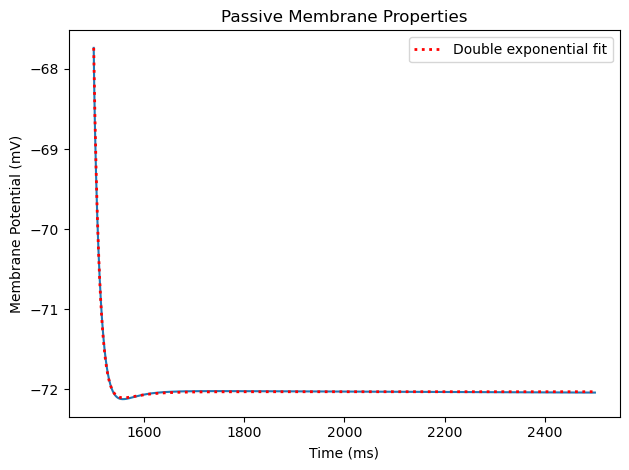

In [9]:
proc_settings = analysis_settings['Passive']
h.celsius = proc_settings['celsius']

sim_passive = Passive(cell, **proc_settings['kwargs'])

X_passive, Y_passive = run_and_plot(
    sim_passive,
    title='Passive Membrane Properties',
    xlabel='Time (ms)',
    ylabel='Membrane Potential (mV)',
    plot_injection_only=True
)

# Add exponential fit
if sim_passive.method == 'exp2':
    plt.gca().plot(*sim_passive.double_exponential_fit(), 'r:', linewidth=2, label='Double exponential fit')
    plt.legend()
elif sim_passive.method == 'exp':
    plt.gca().plot(*sim_passive.single_exponential_fit(), 'r:', linewidth=2, label='Single exponential fit')
    plt.legend()

plt.tight_layout()
plt.show()

### 3.2: Current Clamp Analysis

Measure voltage response to current injection - fundamental for understanding cell excitability.

Injection location: CP_Cell[1].soma[0](0.5)
Recording: CP_Cell[1].soma[0](0.5)._ref_v
Current clamp simulation running...

Number of spikes: 8



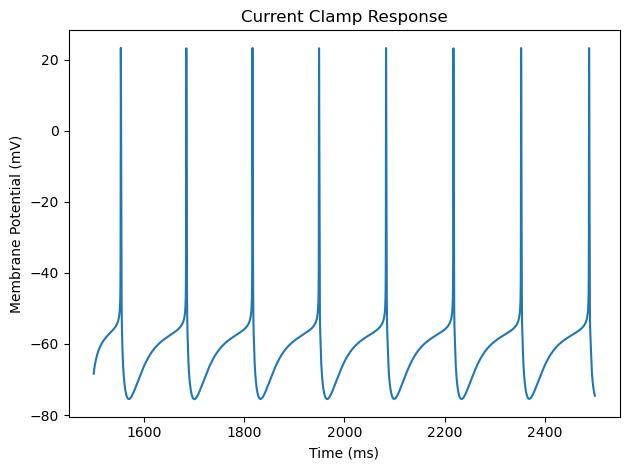

In [10]:
proc_settings = analysis_settings['CurrentClamp']
h.celsius = proc_settings['celsius']

sim_cc = CurrentClamp(cell, **proc_settings['kwargs'])

X_cc, Y_cc = run_and_plot(
    sim_cc,
    title='Current Clamp Response',
    xlabel='Time (ms)',
    ylabel='Membrane Potential (mV)',
    plot_injection_only=True
)

plt.tight_layout()
plt.show()

### 3.3: Impedance Amplitude Profile (ZAP)

Analyze frequency response using a chirp stimulus to measure impedance at different frequencies.

Injection location: CP_Cell[2].soma[0](0.5)
Recording: CP_Cell[2].soma[0](0.5)._ref_v
ZAP current simulation running...

Chirp current injection with frequency changing from 0 to 15 Hz over 15 seconds
Impedance is calculated as the ratio of FFT amplitude of membrane voltage to FFT amplitude of chirp current



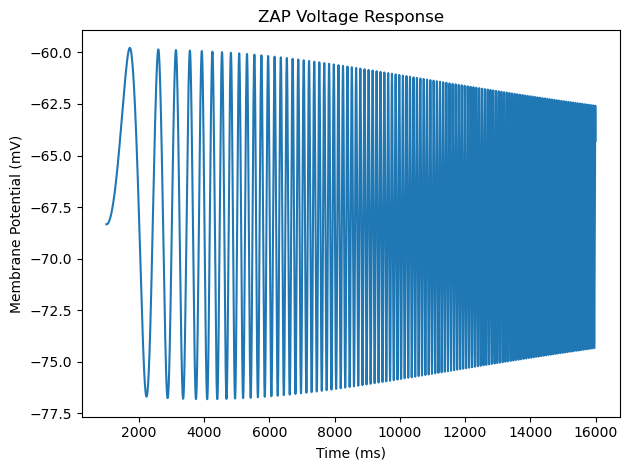

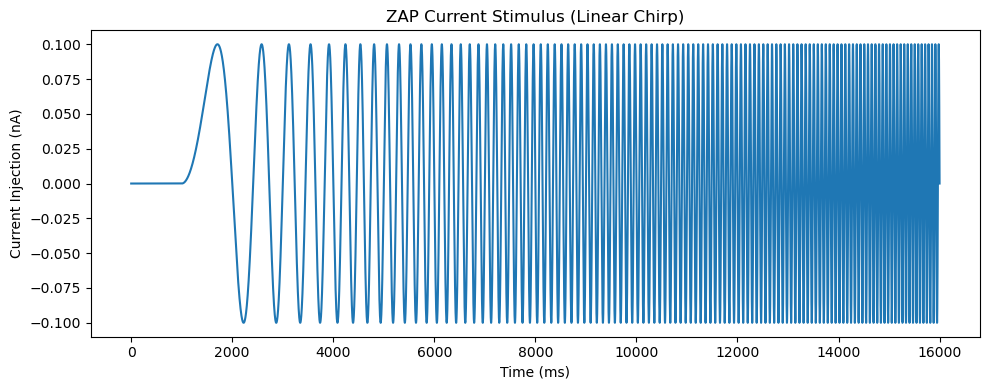

Resonant Peak Frequency: 0.333 (Hz)


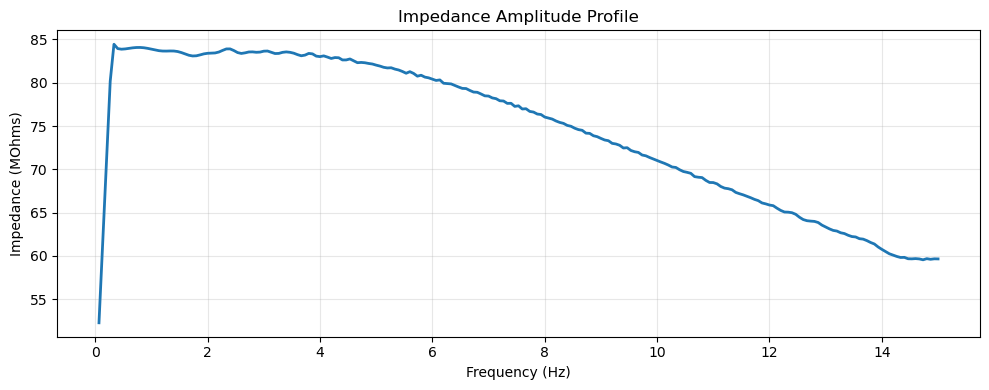

Resonant frequency: 0.33 Hz
Maximum impedance: 84.45 MOhms


In [11]:
proc_settings = analysis_settings['ZAP']
h.celsius = proc_settings['celsius']

sim_zap = ZAP(cell, **proc_settings['kwargs'])

# Plot voltage response
X_zap, Y_zap = run_and_plot(
    sim_zap,
    title='ZAP Voltage Response',
    xlabel='Time (ms)',
    ylabel='Membrane Potential (mV)',
    plot_injection_only=True
)
plt.tight_layout()
plt.show()

# Plot ZAP current stimulus
plt.figure(figsize=(10, 4))
plt.plot(X_zap, sim_zap.zap_vec)
plt.title('ZAP Current Stimulus (Linear Chirp)')
plt.xlabel('Time (ms)')
plt.ylabel('Current Injection (nA)')
plt.tight_layout()
plt.show()

# Plot impedance profile
plt.figure(figsize=(10, 4))
freq, imp = sim_zap.get_impedance(smooth=9)
plt.plot(freq, imp, linewidth=2)
plt.title('Impedance Amplitude Profile')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Impedance (MOhms)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Find resonant frequency
if len(freq) > 0:
    max_imp_idx = np.argmax(imp)
    resonant_freq = freq[max_imp_idx]
    max_imp = imp[max_imp_idx]
    print(f"Resonant frequency: {resonant_freq:.2f} Hz")
    print(f"Maximum impedance: {max_imp:.2f} MOhms")

### 3.4: Frequency-Intensity (FI) Curve Analysis

Measure the relationship between injected current and spike frequency

Injection location: CP_Cell[3].soma[0](0.5)
Recording: CP_Cell[3].soma[0](0.5)._ref_v
Running simulations for FI curve...

Results
    Injection (pA):  number of spikes
0               0.0                 0
1              50.0                 0
2             100.0                 0
3             150.0                10
4             200.0                15
5             250.0                19
6             300.0                23
7             350.0                27
8             400.0                31
9             450.0                36
10            500.0                40
11            550.0                45
12            600.0                49
13            650.0                54
14            700.0                59
15            750.0                64
16            800.0                70
17            850.0                79
18            900.0                 4
19            950.0                 3
20           1000.0                 2
21           1050.0              

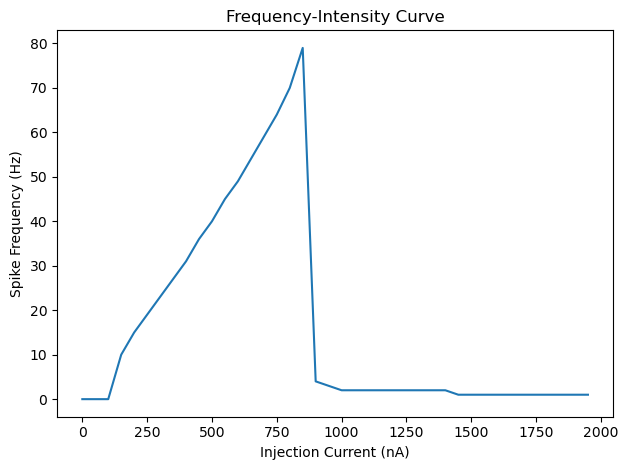

In [12]:
proc_settings = analysis_settings['FI']
h.celsius = proc_settings['celsius']

sim_fi = FI(cell, **proc_settings['kwargs'])

X_fi, Y_fi = run_and_plot(
    sim_fi,
    title='Frequency-Intensity Curve',
    xlabel='Injection Current (nA)',
    ylabel='Spike Frequency (Hz)'
)
plt.tight_layout()
plt.show()

### FI Curve Post-Processing and Analysis

In [13]:
# Fit linear portion of FI curve
m, c, X_fit, Y_fit = fit_slope_to_max_y(X_fi, Y_fi)

# Find rheobase
rheobase = find_rheobase(X_fi, Y_fi)
print(f"  Rheobase (minimum current for firing): {rheobase:.1f} pA")

  Rheobase (minimum current for firing): 150.0 pA
